In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from scipy import stats
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
%matplotlib inline

# Evaluating the House prices regression model

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [3]:
#Create series of continuous variable names, check that all continuous variables are numerical

cont_vars = pd.Series(['saleprice', 'yrsold', 'miscval', 'poolarea','screenporch', 'threessnporch', 'enclosedporch',
                             'wooddecksf', 'openporchsf','garagearea', 'garageyrblt', 'grlivarea', 'lowqualfinsf', 'firstflrsf', 
                             'secondflrsf','totalbsmtsf', 'bsmtunfsf', 'bsmtfinsf1', 'bsmtfinsf2', 'masvnrarea', 
                             'yearbuilt', 'yearremodadd','lotarea', 'lotfrontage'])

#Create series of the categorical variable names

cat_vars = []

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() == False:
        cat_vars.append(var)

cat_vars = pd.Series(cat_vars)

#Check that no variables are in both variable lists

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() & cat_vars.str.contains(var).any():
        print(var)

In [4]:
#Convert categorical variables to numerically coded categories

coded_df = prices_df.copy()
coded_df.sort_values(by='saleprice')
codebook = {}

for var in cat_vars:
    if  coded_df[var].dtype == 'O':
        
        #Create replace dict for each variable
        labels = coded_df[var].unique()
        replace_dict = {k: v for k,v in zip(labels,range(len(labels)))}
        
        #Add var entry to codebook and replace in dataframe
        codebook.update({var: replace_dict})
        coded_df.loc[:,var] = coded_df[var].replace(replace_dict) 

In [5]:
#Boxcox transform our dependent variable, add to list of cont_vars 

coded_df['boxcox_saleprice'] = stats.boxcox(coded_df['saleprice'])[0]
cont_vars = list(cont_vars)
cont_vars.insert(0,'boxcox_saleprice')

In [6]:
#Sort variables by their relevance in the model

#Loop through cat_vars and conduct One-Way Anova across the groups in each cat_var for boxcox_saleprice

import statsmodels.api as sm
from statsmodels.formula.api import ols
F = []
p = []

for var in cat_vars:
    mod_str = 'boxcox_saleprice ~ ' + var
    mod = ols(mod_str, data=coded_df).fit()
    aov_table= sm.stats.anova_lm(mod, typ=2)
    F.append(aov_table['F'][0])
    p.append(aov_table['PR(>F)'][0])
    
#Save results of anova in df with variable names

aov_res = pd.DataFrame(cat_vars, columns=['var'])
aov_res['F'] = F
aov_res['p-value'] = p 
aov_res.sort_values(by='F', ascending=False, inplace=True)

#Create correlation matrix, sort by saleprice
cont_corrs = coded_df[cont_vars].corr()
cont_corrs.sort_values(by='boxcox_saleprice',axis=0, ascending=False, inplace=True)

In [15]:
#Create series of top 10 categorical variables
features = aov_res['var'][:10]

#Append series of continuous variables with greater than 0.5 correlation and remove saleprice vars and secondflrsf
cont_features = list(cont_corrs.loc[cont_corrs['boxcox_saleprice']>0.5, 'boxcox_saleprice'].index)
for var in ['boxcox_saleprice', 'saleprice']: cont_features.remove(var) 
    
features = features.append(pd.Series(cont_features), ignore_index=True)

In [16]:
coded_df.loc[:,features] = coded_df.loc[:,features].fillna(0)

In [17]:
#Remove insignificant features
features = list(features)
for var in ['fullbath', 'fireplacequ', 'exterqual', 'garagearea']: features.remove(var)

#Sort data into dependent and independent variables
Y = coded_df['boxcox_saleprice']
X = coded_df[features]

#Split the data into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 1)

In [18]:
X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     417.3
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        11:29:05   Log-Likelihood:                 1519.6
No. Observations:                1168   AIC:                            -3011.
Df Residuals:                    1154   BIC:                            -2940.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.5940      0.295     15.557      0.000       4.015       5.173
overallqual      0.0322      0.002     13.433      0.000       0.028       0.037
garagecars       0.0253      0.004      5.807      0.000       0.017       0.034
totrmsabvgrd     0.0061      0.002      2.773      0.006       0.002       0.010
fireplaces       0.0296      0.004      8.362      0.000       0.023       0.037
foundation      -0.0082      0.003     -2.444      0.015      -0.015      -0.002
heatingqc       -0.0094      0.003     -3.751      0.000      -0.014      -0.004
bsmtfintype1    -0.0031      0.001     -2.284      0.023      -0.006      -0.000
grlivarea     5.991e-05   8.22e-06      7.291      0.000    4.38e-05     7.6e-05
totalbsmtsf   2.191e-05   8.74e-06      2.506      0.012    4.76e-06    3.91e-05
firstflrsf    2.916e-05      1e-05      2.911      0.004    9.51e-06    4.88e-05
yearbuilt        0.0006      0.000      5.557      0.000       0.000       0.001
yearremodadd     0.0008      0.000      6.096      0.000       0.001       0.001
garageyrblt    1.83e-05   5.55e-06      3.298      0.001    7.41e-06    2.92e-05
==============================================================================
Omnibus:                      724.423   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21954.215
Skew:                          -2.343   Prob(JB):                         0.00
Kurtosis:                      23.716   Cond. No.                     6.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

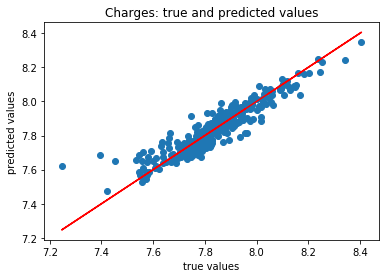

Mean absolute error of the prediction is: 0.04301854507421595
Mean squared error of the prediction is: 0.003684904615540441
Root mean squared error of the prediction is: 0.06070341518844258
Mean absolute percentage error of the prediction is: 0.5517609416040635


In [22]:
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

The model did a very good job of predicting the test data. All error metrics are very close to 0. The model appears to mis-predict the lower values in the dataset.

# I will evaluate the performance of the model without removing the insignificant features

In [28]:
#Create series of top 10 categorical variables
features = aov_res['var'][:10]

#Append series of continuous variables with greater than 0.5 correlation and remove saleprice vars and secondflrsf
cont_features = list(cont_corrs.loc[cont_corrs['boxcox_saleprice']>0.5, 'boxcox_saleprice'].index)
for var in ['boxcox_saleprice', 'saleprice']: cont_features.remove(var) 
    
features = features.append(pd.Series(cont_features), ignore_index=True)

In [29]:
#Sort data into dependent and independent variables
Y = coded_df['boxcox_saleprice']
X = coded_df[features]

#Split the data into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 1)

In [30]:
X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     318.6
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        11:37:45   Log-Likelihood:                 1520.5
No. Observations:                1168   AIC:                            -3005.
Df Residuals:                    1150   BIC:                            -2914.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.6565      0.310     15.001      0.000       4.047       5.266
overallqual      0.0319      0.002     13.132      0.000       0.027       0.037
garagecars       0.0198      0.006      3.071      0.002       0.007       0.033
fullbath         0.0023      0.005      0.421      0.674      -0.008       0.013
totrmsabvgrd     0.0062      0.002      2.803      0.005       0.002       0.011
fireplaces       0.0283      0.005      5.951      0.000       0.019       0.038
foundation      -0.0083      0.003     -2.470      0.014      -0.015      -0.002
heatingqc       -0.0092      0.003     -3.629      0.000      -0.014      -0.004
fireplacequ      0.0016      0.003      0.614      0.540      -0.004       0.007
bsmtfintype1    -0.0031      0.001     -2.273      0.023      -0.006      -0.000
exterqual       -0.0019      0.004     -0.460      0.646      -0.010       0.006
grlivarea     5.795e-05   8.66e-06      6.691      0.000     4.1e-05    7.49e-05
garagearea    2.294e-05   2.08e-05      1.102      0.271   -1.79e-05    6.38e-05
totalbsmtsf   2.133e-05   8.83e-06      2.416      0.016    4.01e-06    3.87e-05
firstflrsf    2.843e-05   1.01e-05      2.827      0.005     8.7e-06    4.82e-05
yearbuilt        0.0006      0.000      5.108      0.000       0.000       0.001
yearremodadd     0.0008      0.000      5.960      0.000       0.001       0.001
garageyrblt   1.771e-05   5.65e-06      3.133      0.002    6.62e-06    2.88e-05
==============================================================================
Omnibus:                      728.081   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22410.769
Skew:                          -2.356   Prob(JB):                         0.00
Kurtosis:                      23.936   Cond. No.                     6.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

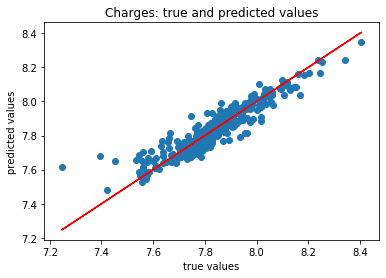

Mean absolute error of the prediction is: 0.042859030984940455
Mean squared error of the prediction is: 0.0036687360576642884
Root mean squared error of the prediction is: 0.060570092105463144
Mean absolute percentage error of the prediction is: 0.5496452050386629


In [31]:
X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

The model actually perormed slightly better with the additional, insignificant features. 